<a href="https://colab.research.google.com/github/combineinator/combine-inator-acikhack2021/blob/main/Combineinator_Library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## parent class

In [ ]:
class CombineInator:
  
  def __init__(self):
    self.source = ""


  def translate_model(self, source):

    if source == "en":

      tokenizer_trs = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-trk")
      model_trs = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-trk")
      pipe_trs = "translation_en_to_trk"

    elif source == "tr":

      tokenizer_trs = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-tr-en")
      model_trs = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-tr-en")
      pipe_trs = "translation_tr_to_en"
      

    return model_trs, tokenizer_trs, pipe_trs 

  
  def translate(self, pipe, model, tokenizer, response):
  
    translator = pipeline(pipe, model=model, tokenizer=tokenizer)
    
    # elde edilen cümleleri hedeflnen dile çevirme:
    trans = translator(response)[0]["translation_text"]

    return trans
  
  

## web scraper (child)

In [ ]:
import requests
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from os.path import exists, basename, splitext

In [ ]:
class WikiWebScraper(CombineInator):
 
  def __init__(self):
    
    self.__HEADERS_PARAM = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.104 Safari/537.36"}
 
  
  def category_scraping_interface(self, CATEGORY_QUERY, LIMIT, SAVE_PATH, PAGE_PER_SAVE, REMOVE_NUMBERS, JUST_TITLE_ANALYSIS, TEXT_INTO_SENTENCES_PARAM):
 
    """
    
    Kategorik verilerin ayıklanma işlemleri bu fonksiyonda yönetilir.
    
    :param CATEGORY_QUERY: Ayıklanacak kategori sorgusu.
    :type CATEGORY_QUERY: str

    :param SAVE_PATH: Ayıklanan verinin kaydedileceği yol.
    :type SAVE_PATH: str

    :param LIMIT: Ayıklanması istenen veri limiti. Verilmediği taktirde tüm verileri çeker.
    :type LIMIT: int

    :param PAGE_PER_SAVE: Belirlenen aralıkla ayıklanan kategorik verinin kaydedilmesini sağlar.
    :type PAGE_PER_SAVE: int

    :param TEXT_INTO_SENTENCES_PARAM: Ayıklanan verilerin cümleler halinde mi, yoksa metin halinde mi kaydedileceğini belirler.
    :type TEXT_INTO_SENTENCES_PARAM: bool

    :param REMOVE_NUMBERS: Ayıklanan verilerden rakamların silinip silinmemesini belirler.
    :type REMOVE_NUMBERS: bool

    :param JUST_TITLE_ANALYSIS: Sadece sayfaların başlık bilgilerinin toplanmasını sağlar.
    :type JUST_TITLE_ANALYSIS: bool
    
    """
 
    sub_list = []
    page_list = []
    text_list = []
 
    page_list, sub_list = self.first_variable(CATEGORY_QUERY, (LIMIT - len(text_list)))
    fv = True
        
    if page_list and sub_list is not None:        
      with tqdm(total=LIMIT, desc="Sayfa taranıyor.") as pbar:
        while len(page_list) < LIMIT:
 
          if fv is True:
            pbar.update(len(page_list))
            fv = False 
          
          temp_soup = ""
 
          if len(sub_list) == 0:
            break
        
          temp_soup = self.sub_scraper(sub_list[0])    
 
          if (temp_soup == False):
            break   
 
          del sub_list[0]   
 
          sub_list = sub_list + self.sub_category_scraper(temp_soup)
 
          temp_page_scraper = self.page_scraper(temp_soup, (LIMIT - len(page_list)))  
 
          if temp_page_scraper is not None:
            for i in temp_page_scraper:
              if i not in page_list:
                page_list.append(i)
                pbar.update(1)            
 
          if len(sub_list) == 0:
            sub_list = sub_list + self.sub_category_scraper(temp_soup)
 
      temp_range = 0
      loop_counter = 0
 
      if JUST_TITLE_ANALYSIS is False: 
        for i in range(PAGE_PER_SAVE, len(page_list)+PAGE_PER_SAVE, PAGE_PER_SAVE):
 
          if loop_counter == (len(page_list) // PAGE_PER_SAVE):
            PATH = SAVE_PATH + "/" + CATEGORY_QUERY + "_" + str(temp_range) + " - " + str(len(page_list)) + ".txt"
            temp_text_list = self.text_into_sentences(self.text_scraper(page_list[temp_range:i], (len(page_list) % PAGE_PER_SAVE)), REMOVE_NUMBERS,TEXT_INTO_SENTENCES_PARAM)
          else:
            PATH = SAVE_PATH + "/" + CATEGORY_QUERY + "_" + str(temp_range) + " - " + str(i) + ".txt"
            temp_text_list = self.text_into_sentences(self.text_scraper(page_list[temp_range:i], PAGE_PER_SAVE), REMOVE_NUMBERS, TEXT_INTO_SENTENCES_PARAM)
                      
          text_list += temp_text_list
 
          self.save_to_csv(PATH, temp_text_list)         
          temp_range = i
          loop_counter += 1
 
        print("\n\n"+str(len(page_list)) + " adet sayfa bulundu ve içerisinden " + str(len(text_list)) + " satır farklı metin ayrıştırıldı.")
        return text_list
 
      else:
        PATH = SAVE_PATH + "/" + CATEGORY_QUERY + "_" + str(len(page_list)) + "_page_links" + ".txt"
        self.save_to_csv(PATH, page_list, JUST_TITLE_ANALYSIS)
        print("\n\n"+str(len(page_list)) + " adet sayfa bulundu ve sayfaların adresleri \"" + PATH + "\" konumunda kaydedildi.")
        return page_list
 
    else:
        print("Aranan kategori bulunamadı.")
  
 
  def categorical_scraper(self, CATEGORY_QUERY, save_path, LIMIT=-1, page_per_save=10000, text_into_sentences_param=True, remove_numbers=False, just_title_analysis=False):
    
    """
    Wikipedia üzerinden kategorik olarak veri çekmek için kullanılır.
 
    :param CATEGORY_QUERY: Ayıklanacak kategori sorgusu.
    :type CATEGORY_QUERY: str

    :param save_path: Ayıklanan verinin kaydedileceği yol.
    :type save_path: str

    :param LIMIT: Ayıklanması istenen veri limiti. Verilmediği taktirde tüm verileri çeker.
    :type LIMIT: int

    :param page_per_save: Belirlenen aralıkla ayıklanan kategorik verinin kaydedilmesini sağlar.
    :type page_per_save: int

    :param text_into_sentences_param: Ayıklanan verilerin cümleler halinde mi, yoksa metin halinde mi kaydedileceğini belirler.
    :type text_into_sentences_param: bool

    :param remove_numbers: Ayıklanan verilerden rakamların silinip silinmemesini belirler.
    :type remove_numbers: bool

    :param just_title_analysis: Sadece sayfaların başlık bilgilerinin toplanmasını sağlar.
    :type just_title_analysis: bool
 
    """

    if LIMIT == -1:
      LIMIT = 9999999
 
    CATEGORY_QUERY = CATEGORY_QUERY.replace(" ","_")
    
    return_list = self.category_scraping_interface(CATEGORY_QUERY, LIMIT, save_path, page_per_save, remove_numbers, just_title_analysis, text_into_sentences_param)
 
    if return_list is None:
        return []
    else:
        return return_list
 
  
  
  def text_scraper_from_pagelist(self, page_list_path, save_path, page_per_save=10000, remove_numbers=False, text_into_sentences_param=True, RANGE=None):
 
    """
 
    Wikipedia üzerinden kategorik olarak veri çekmek için kullanılır.
 
    :param page_list_path: Toplanan sayfaların başlık bilgilerinin çıkartılmasını sağlar
    :type page_list_path: str
 
    :param save_path: Ayıklanan verinin kaydedileceği yol.
    :type save_path: str
 
    :param page_per_save: Belirlenen aralıkla ayıklanan kategorik verinin kaydedilmesini sağlar.
    :type page_per_save: int
 
    :param text_into_sentences_param: Ayıklanan verilerin cümleler halinde mi, yoksa metin halinde mi kaydedileceğini belirler.
    :type text_into_sentences_param: bool
 
    :param remove_numbers: Ayıklanan verilerden rakamların silinip silinmemesini belirler.
    :type remove_numbers: bool
 
    :param RANGE: Ayıklnacak verilerin aralığını belirler. "RANGE = [500,1000]" şeklinde kullanılır. Verilmediği zaman tüm veri ayıklanır.
    :type RANGE: list
 
    """
  
    page_list = []
    text_list = []
 
    with open(page_list_path, 'r') as f:
      page_list = [line.strip() for line in f]
 
    if RANGE is not None:
      page_list = page_list[RANGE[0]:RANGE[1]]
 
    temp_range = 0
    loop_counter = 0
 
    for i in range(page_per_save, len(page_list)+page_per_save, page_per_save):
      
      if loop_counter == (len(page_list) // page_per_save):
        PATH = save_path + "/" + "scraped_page" + "_" + str(temp_range) + " - " + str(len(page_list)) + ".txt"
        temp_text_list = self.text_into_sentences(self.text_scraper(page_list[temp_range:i], (len(page_list) % page_per_save), True), remove_numbers, text_into_sentences_param)
      else:
        PATH = save_path + "/" + "scraped_page" + "_" + str(temp_range) + " - " + str(i) + ".txt"
        temp_text_list = self.text_into_sentences(self.text_scraper(page_list[temp_range:i], page_per_save, True), remove_numbers, text_into_sentences_param)
 
      text_list += temp_text_list
 
      save_to_csv(PATH, temp_text_list)
      temp_range = i
      loop_counter += 1
 
    print("\n\"" + page_list_path + "\" konumundaki " + str(len(page_list)) + " adet sayfa içerisinden " + str(len(text_list)) + " satır metin ayrıştırıldı.")
    
    return text_list
 
  
  
  def page_scraper(self, page_soup, LIMIT):
 
    """
 
    Gönderilen wikipedia SOUP objesinin içerisindeki kategorik içerik sayfaları döndürür.

    :param page_soup: Wikipedia kategori sayfasının SOUP objesidir.
    
    :param LIMIT: Ayıklanacaj sayfa limitini belirler.
    :type LIMIT: int
 
    """
 
    page_list = []
 
    try:
        pages = page_soup.find("div", attrs={"id": "mw-pages"}).find_all("a")
        for page in pages[1:]:
            if len(page_list) == LIMIT:
                break
            else:
                page_list.append([page.text, page["href"]])
        return page_list
   
    except:
      pass
  
  
  def sub_category_scraper(self, sub_soup):
 
    """
 
    Gönderilen wikipedia SOUP objesinin içerisindeki alt kategorileri döndürür.

    :param sub_soup: Alt kategori sayfasının SOUP objesidir.
 
    """
 
    sub_list = []
 
    try:
        sub_categories = sub_soup.find_all("div", attrs={"class": "CategoryTreeItem"})
        for sub in sub_categories[1:]:
            sub_list.append([sub.a.text, sub.a["href"]])
 
        return sub_list
 
    except:
         print("Aranan kategori için yeterli sayfa bulunamadı.")
 
 
  
  def sub_scraper(self, sub):
 
    """
 
    Fonksiyona gelen wikipedia kategori/alt kategorisinin SOUP objesini döndürür.

    :param sub: Alt kategori sayfasının linkini içerir.
 
    """
 
    try:
        req = requests.get("https://tr.wikipedia.org" + str(sub[1]), headers=self.__HEADERS_PARAM)
        soup = BeautifulSoup(req.content, "lxml")
        return soup
 
    except:
        print("\nAlt kategori kalmadı")
        return False
 
 
  def text_scraper(self, page_list, LIMIT, IS_FROM_TXT=False):
 
    """
 
    Önceden ayıklanmış sayfa listesini içerisindeki sayfaları ayıklayarak içerisindeki metin listesini döndürür.

    :param page_list: Sayfa listesini içerir.

    :parama LIMIT: Ayıklanacaj sayfa limitini belirler.
    :type LIMIT: int

    :param IS_FROM_TXT: Ayıklanacak sayfanın listeleden mi olup olmadığını kontrol eder.
 
    """
 
    text_list = []
    
    with tqdm(total=LIMIT, desc="Sayfa Ayrıştırılıyor") as pbar:
      for page in page_list:
 
          if len(text_list) == LIMIT:
              break
          if IS_FROM_TXT is False:
            req = requests.get("https://tr.wikipedia.org" + str(page[1]), headers=self.__HEADERS_PARAM)
          else:
            req = requests.get("https://tr.wikipedia.org" + str(page), headers=self.__HEADERS_PARAM)
          soup = BeautifulSoup(req.content, "lxml")
          page_text = soup.find_all("p")
          temp_text = ""
 
          for i in page_text[1:]:
              temp_text = temp_text + i.text
 
          text_list.append(temp_text)
          pbar.update(1)
 
    return text_list
 
 
 
  def first_variable(self, CATEGORY_QUERY, LIMIT):
 
    """
 
    Sorguda verilen kategorinin doğruluğunu kontrol eder ve eğer sorgu doğru ise ilk değerleri ayıklar.

    :param CATEGORY_QUERY: Ayıklanacak kategori sorgusu.
    :type CATEGORY_QUERY: str

    :param LIMIT: Ayıklanması istenen veri limiti. Verilmediği taktirde tüm verileri çeker.
    :type LIMIT: int
 
    """
    
    first_req = requests.get("https://tr.wikipedia.org/wiki/Kategori:" + CATEGORY_QUERY, headers=self.__HEADERS_PARAM)
    first_soup = BeautifulSoup(first_req.content, "lxml")
    page_list = self.page_scraper(first_soup, LIMIT)
    sub_list = self.sub_category_scraper(first_soup)
 
    return page_list, sub_list
 
  
  
  def text_into_sentences(self, texts, remove_numbers, text_into_sentences_param):
 
    """
 
    Metin verilerini cümlelerine ayıklar.

    :param texts: Düzlenecek metin verisi.

    :param remove_numbers: Sayıların temizlenip temizlenmeyeceğini kontrol eder.

    :param text_into_sentences_param: Metinlerin cümlelere çevrilip çevrilmeyeceğini kontrol eder.
 
    """
  
    flatlist = []   
    sent_list = []
 
    texts = self.sentence_cleaning(texts, remove_numbers)
    
    if text_into_sentences_param is True:
      for line in texts:
        temp_line = re.split(r'(?<![IVX0-9]\S)(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', line)
        for i in temp_line:
          if len(i.split(" ")) > 3:
            sent_list.append(i)
    else:
      sent_list = texts
 
    flatlist = list(dict.fromkeys(self.flat(sent_list, flatlist)))
 
    return flatlist
 
 
 
  def flat(self, sl,fl): 
    
    """
 
    Metinler, cümlelerine ayırıldıktan sonra listenin düzlenmesine yarar.

    :param sl: Yollanan listle.

    :param fl: Düzlemem liste.

    
 
    """
 
    for e in sl:                
        if type(e) == list:     
            flat(e,fl)             
        elif len(e.split(" "))>3:
          fl.append(e)  
    return fl
 
 
 
  def sentence_cleaning(self, sentences, remove_numbers):
 
    """
 
    Ayıklanan wikipedia verilerinin temizlenmesi bu fonksiyonda gerçekleşir.

    :param sentences: Temizlenmek için gelen veri seti.
    
    :param remove_numbers: Sayıların temizlenip temizlenmeyeceğini kontrol eder.
 
    """
    
    return_list = []
 
    if remove_numbers is False:
      removing_func = '[^[a-zA-ZğüışöçĞÜIİŞÖÇ0-9.,!:;`?%&\-\'" ]'
    else:
      removing_func = '[^[a-zA-ZğüışöçĞÜIİŞÖÇ.,!:;`?%&\-\'" ]'
 
    for input_text in sentences:
        try:            
            input_text = re.sub(r'(\[.*?\])', '', input_text)
            input_text = re.sub(r'(\(.*?\))', '', input_text)
            input_text = re.sub(r'(\{.*?\})', '', input_text)
            input_text = re.sub(removing_func, '', input_text)
            input_text = re.sub("(=+(\s|.)*)", "", input_text)
            input_text = re.sub("(\s{2,})", "", input_text)
            input_text = input_text.replace("''", "")
            input_text = input_text.replace("\n", "")            
            return_list.append(input_text)
        except:
            pass
    
    return return_list
 
 
  def save_to_csv(self, PATH, data, is_just_title_analysis=False):
 
    """
 
    Verilerin 'csv' formatında kaydedilmesini bu fonksiyonda gerçekleşir.

    :param PATH: Kaydedilecek yol.

    :param data: Kaydedilecek veri.

    :param is_just_title_analysis: Sadece analiz yapılıp yapılmadığını kontrol eder.
 
    """
    
    if is_just_title_analysis is False:
      with open(PATH, "w") as output:
        for i in data:
          output.write(i+"\n")
 
    else:
      temp_data = []
      for i in data:
        temp_data.append(i[1])
      with open(PATH, "w") as output:
        for i in temp_data:
          output.write(i+"\n")

### Example usage

In [ ]:
library = WikiWebScraper()

In [ ]:
PATH = "/content/"

In [ ]:
library.categorical_scraper("savaş", PATH, 20, text_into_sentences_param=False)

Sayfa Ayrıştırılıyor: 100%|██████████| 20/20 [00:04<00:00,  4.68it/s]



20 adet sayfa bulundu ve içerisinden 20 satır farklı metin ayrıştırıldı.


['HavaCepheKaraDeniz Uzay ZırhlıBiyolojikSüvarilerKimyasalPiyadeNükleer GerillaGayrinizamiKuşatmaTopyekn savaşCepheYakıp yıkmaAsker operasyon planıEkonomikAmbargoOperasyonelPsikolojikAsker eğitimOrduTümenTaburGrupAtHelikopterSavaş filiTahkimatTankDonanımUçakSavaş veya harp; ülkeler, hükmetler, bloklar ya da bir ülke içerisindeki toplumlar, isyancılar veya milisler gibi büyük gruplar arasında gerçekleşen silahlı mücadeledir.Savaşlar genellikle dini, mill, siyasi ve ekonomik amaçlara ulaşmak için gerçekleştirilir. Kullanılan silahlara, amaçlara, taraflara ve gerçekleştiği yerlere göre farklı şekillerde adlandırılır: nükleer savaş, soğuk savaş, iç savaş, dini savaş , dünya savaşı, gerilla savaşı gibi.Günümüzde savaşlar Birleşmiş Milletler tarafından bazı temellere ve kurallara dayandırılmıştır. Geçmişte yapılan savaşların aksine günümüzdeki savaşlarda özellikle sivillerin öldürülmesini engellemek, ülke ya da kitleleri yok etmektense onları güçsüz bırakmak güdülmektedir. Ancak buna rağmen 

## text2speech (child)

In [ ]:
!pip install transformers
!pip install simpletransformers

     |████████████████████████████████| 2.6 MB 4.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.3 MB/s 
     |████████████████████████████████| 636 kB 45.9 MB/s 
     |████████████████████████████████| 895 kB 49.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 221 kB 4.1 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 
     |████████████████████████████████| 8.0 MB 32.8 MB/s 
     |████████████████████████████████| 124 kB 46.1 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 264 kB 50.9 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 170 kB 46.1 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
     |████████████████████████████████| 133 kB 48.6 MB/s 
     |████████████████████████████████| 63 kB

In [ ]:
from os import path
from IPython.display import Audio
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM, Wav2Vec2Processor, Wav2Vec2ForCTC
import librosa
import torch

In [ ]:
class speechModule(CombineInator):

  def __init__(self):
    self.SAMPLING_RATE = 16_000
    self.git_repo_url = 'https://github.com/CorentinJ/Real-Time-Voice-Cloning.git'
    self.project_name = splitext(basename(self.git_repo_url))[0]
    
  def get_repo(self):

    """

    Metinin sese çevrilmesi sırasında kullanılacak ses klonlama kütüphanesini çeker.

    """

    if not exists(self.project_name):
      # clone and install
      !git clone -q --recursive {self.git_repo_url}
      # install dependencies
      !cd {self.project_name} && pip install -q -r requirements.txt
      !pip install -q gdown
      !apt-get install -qq libportaudio2
      !pip install -q https://github.com/tugstugi/dl-colab-notebooks/archive/colab_utils.zip
      # download pretrained model
      !cd {self.project_name} && wget https://github.com/blue-fish/Real-Time-Voice-Cloning/releases/download/v1.0/pretrained.zip && unzip -o pretrained.zip
    from sys import path as syspath
    syspath.append(self.project_name)
  
  def wav2vec_model(self, source):

    """

    Sesin metne çevrilmesi sırasında kullanılacak ilgili dile göre wav2vec modelini belirler.

    :param source: ses dosyası dili ("tr" / "en")
    :type source: str

    """

    processor = None
    model = None

    if source == "en":
      processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
      model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
      
    elif source =="tr":
      processor = Wav2Vec2Processor.from_pretrained("m3hrdadfi/wav2vec2-large-xlsr-turkish")
      model = Wav2Vec2ForCTC.from_pretrained("m3hrdadfi/wav2vec2-large-xlsr-turkish")  

    return model, processor

    
  def speech2text(self, audio_file, model, processor, language):

    """

    Girdi olarak verilen sesi metne çevirir.

    :param audio_file: ses dosyasının yer aldığı dizin
    type audio_file: str
    
    :param model: sesin metne çevrilmesi esnasında kullanılacak huggingface kütüphanesinden çekilen model

    :param processor: sesin metne çevrilmesi esnasında kullanılacak huggingface kütüphanesinden çekilen istemci

    :param language: girdi olarak verilen ses doyasının dili ("tr" / "en")
    :type language: str

    """

    #load any audio file of your choice
    speech, rate = librosa.load(audio_file, sr=self.SAMPLING_RATE)
    input_values = processor(speech, sampling_rate=self.SAMPLING_RATE, return_tensors = 'pt').input_values

    #Store logits (non-normalized predictions)
    logits = model(input_values).logits

    #Store predicted id's
    predicted_ids = torch.argmax(logits, dim =-1)

    #decode the audio to generate text
    response = processor.decode(predicted_ids[0]).lower()

    if language == "en":
      response = ">>tur<< " + response

    return response
  
  
  def text2speech(self, audio, translation):

    """

    Metini sese çevirir.

    :param audio: klonlanacak ses doyasının yer aldığı dizin
    :type audio: str

    :param translation: çevirisi yapılmış metin
    :type translation: str

    """
    from numpy import pad as pad
    from synthesizer.inference import Synthesizer
    from encoder import inference as encoder
    from vocoder import inference as vocoder
    from pathlib import Path

    encoder.load_model(self.project_name / Path("encoder/saved_models/pretrained.pt"))
    synthesizer = Synthesizer(self.project_name / Path("synthesizer/saved_models/pretrained/pretrained.pt"))
    vocoder.load_model(self.project_name / Path("vocoder/saved_models/pretrained/pretrained.pt"))

    embedding = encoder.embed_utterance(encoder.preprocess_wav(audio, self.SAMPLING_RATE))
    specs = synthesizer.synthesize_spectrograms([translation], [embedding])
    generated_wav = vocoder.infer_waveform(specs[0])
    generated_wav = pad(generated_wav, (0, self.SAMPLING_RATE), mode="constant")

    return Audio(generated_wav, rate=self.SAMPLING_RATE, autoplay=True)

  


  
  def speech2text2trans2speech(self, filename:str, source_lang:str, output_type:str = "text"):
    
    """

    Aldığı ses dosyasını text'e dönüştürüp, hedeflenen dile çeviren ve çevirdiği metni ses olarak
    döndüren fonksiyon.
  
    :param filename: Ses dosyasının adı
    :type filename: str

    :param lang: Ses dosyası dili ("en"/"tr") 
    :type lang: str 
    
    """

    output_types = ["text", "speech"]
    source_languages = ["en", "tr"]

    if source_lang not in source_languages:
      print("Kaynak dil olarak yalnızca 'en' ve 'tr' parametreleri kullanılabilir.")
      return None
    
    if output_type not in output_types:
      print("Çıkış türü için yalnızca 'text' ve 'speech' parametreleri desteklenmektedir.")
      return None

    if source_lang == "en" and output_type=="speech":
      print("Üzgünüz, text2speech modülümüzde Türkçe dil desteği bulunmamaktadır.\n")
      return None

    model_trs, tokenizer_trs, pipe_trs = CombineInator.translate_model(self, source_lang)

    model_s2t, processor_s2t = self.wav2vec_model(source_lang)
    
    input_text = self.speech2text(filename, model_s2t, processor_s2t, source_lang)
    print(input_text)
    translation = CombineInator.translate(self, pipe_trs, model_trs, tokenizer_trs, input_text)
  
    if output_type == "text":
      return translation
  
    else:
      print("\n" + translation + "\n")
      return self.text2speech(filename, translation)

### Example usage

In [ ]:
filename = "_path_to_wav_file" # ses dosyası pathi verilmelidir

In [ ]:
speechM = speechModule()

In [ ]:
speechM.get_repo()

     |████████████████████████████████| 80 kB 3.5 MB/s 
     |████████████████████████████████| 676 kB 26.6 MB/s 
     |████████████████████████████████| 10.3 MB 30.7 MB/s 
     |████████████████████████████████| 14.5 MB 72 kB/s 
     |████████████████████████████████| 241 kB 47.5 MB/s 
     |████████████████████████████████| 8.3 MB 46.6 MB/s 
     |████████████████████████████████| 66 kB 4.3 MB/s 
     |████████████████████████████████| 1.1 MB 35.2 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
     |████████████████████████████████| 59.9 MB 37 kB/s 
     |████████████████████████████████| 317 kB 48.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel~=4.10, but you have ipykernel 6.2.0 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.26.0 which is incompatible.
da

In [ ]:
speechM.speech2text2trans2speech(filename, "tr", "speech")

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/840k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/158 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/372 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/138 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

merhava yarın partiye gelecek misiniz


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)



Will you come to the party tomorrow?

Loaded encoder "pretrained.pt" trained to step 1564501
Synthesizer using device: cuda
Building Wave-RNN
Trainable Parameters: 4.481M
Loading model weights at Real-Time-Voice-Cloning/vocoder/saved_models/pretrained/pretrained.pt
Trainable Parameters: 30.870M
Loaded synthesizer "pretrained.pt" trained to step 295000
+----------+---+
| Tacotron | r |
+----------+---+
|   295k   | 2 |
+----------+---+
 

| Generating 1/1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)




Done.

{| ████████████████ 38000/38400 | Batch Size: 4 | Gen Rate: 3.1kHz | }

## Lxmert (child)

In [ ]:
!git clone https://github.com/hila-chefer/Transformer-MM-Explainability

import os
os.chdir(f'./Transformer-MM-Explainability')

!pip install -r requirements.txt

In [ ]:
%cd Transformer-MM-Explainability

In [ ]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from tqdm import tqdm
from lxmert.lxmert.src.ExplanationGenerator import GeneratorOurs, GeneratorBaselines, GeneratorOursAblationNoAggregation
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import visualization
import requests

In [ ]:
class Lxmert(CombineInator):

  def __init__(self):
    self.OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
    self.ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
    self.VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
    self.model_lrp = self.ModelUsage()
    self.lrp = GeneratorOurs(self.model_lrp)
    self.baselines = GeneratorBaselines(self.model_lrp)
    self.vqa_answers = utils.get_data(self.VQA_URL)
    
  class ModelUsage:
    
    """

    Model kullanımı için sınıf yapısı

    """
    
    def __init__(self, use_lrp=True):
      self.VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

      self.vqa_answers = utils.get_data(self.VQA_URL)

      # load models and model components
      self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
      self.frcnn_cfg.MODEL.DEVICE = "cuda"

      self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

      self.image_preprocess = Preprocess(self.frcnn_cfg)

      self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

      if use_lrp:
          self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
      else:
          self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

      self.lxmert_vqa.eval()
      self.model = self.lxmert_vqa

      # self.vqa_dataset = vqa_data.VQADataset(splits="valid")

    def forward(self, item):
      
      PATH, question = item
      
      self.image_file_path = PATH

      # run frcnn
      images, sizes, scales_yx = self.image_preprocess(PATH)
      output_dict = self.frcnn(
          images,
          sizes,
          scales_yx=scales_yx,
          padding="max_detections",
          max_detections= self.frcnn_cfg.max_detections,
          return_tensors="pt"
      )
      inputs = self.lxmert_tokenizer(
          question,
          truncation=True,
          return_token_type_ids=True,
          return_attention_mask=True,
          add_special_tokens=True,
          return_tensors="pt"
      )
      self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
      self.text_len = len(self.question_tokens)
      # Very important that the boxes are normalized
      normalized_boxes = output_dict.get("normalized_boxes")
      features = output_dict.get("roi_features")
      self.image_boxes_len = features.shape[1]
      self.bboxes = output_dict.get("boxes")
      self.output = self.lxmert_vqa(
          input_ids=inputs.input_ids.to("cuda"),
          attention_mask=inputs.attention_mask.to("cuda"),
          visual_feats=features.to("cuda"),
          visual_pos=normalized_boxes.to("cuda"),
          token_type_ids=inputs.token_type_ids.to("cuda"),
          return_dict=True,
          output_attentions=False,
      )
      return self.output
  
  def ceviri(self, text: str, lang_src='tr'):
    
    """
    
    Aldığı metni istenilen dile çeviren fonksiyon.

    :param text: Orjinal metin
    :type text: str

    :param lang_src: Metin dosyasının dili (kaynak dili)
    :type lang_src: str
    
    :param lang_tgt: Çevrilecek dil (hedef dil)
    :param lang_tgt: str

    :return: translated text

    """

    if lang_src == "en":
      text = ">>tur<< " + text

    model, tokenizer, pipeline = CombineInator.translate_model(self, lang_src)
    return (CombineInator.translate(self, pipeline, model, tokenizer, text))
  
  
  def save_image_vis(self, image_file_path, bbox_scores):
    """
    Resim üzerinde sorunun cevabını çizer ve kaydeder.

    :param image_file_path: imgenin yer aldığı dizin
    :type image_file_path: str

    :param bbox_scores: tespit edilen nesnelerin skorlarını içeren tensor
    :type bbox_scores: tensor

    """


    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
      [x, y, w, h] = self.model_lrp.bboxes[0][index]
      curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
      new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
      mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite('lxmert/lxmert/experiments/paper/new.jpg', img)
  
  
  
  def get_image_and_question(self, img_path:str, soru:str):
    
    """

    Input olarak verilen imge ve soruyu döndürür.

    :param img_path: Soru sorulacak imgenin path bilgisi
    :type img_path: str

    :param soru: Resim özelinde modele sorulacak olan Türkçe soru 
    :type soru: str

    :return: image_scores, text_scores

    """
    
    ing_soru = self.ceviri(soru, "tr")
    R_t_t, R_t_i = self.lrp.generate_ours((img_path, ing_soru), use_lrp=False, normalize_self_attention=True, method_name="ours")
    
    return R_t_i[0], R_t_t[0]  

  
  def resim_uzerinden_soru_cevap(self, PATH:str, turkce_soru:str):
    """
    Verilen girdi imgesi üzerinden yine veriler sorular ile sorgulama yapılabilmesini
    sağlar. 

    PATH: imgenin path bilgisi
    turkce_soru: Resimde cevabı aranacak soru
    """

    #Eğer sorgulanacak resim local'de yok ve internet üzerinden bir resim ise:
    if PATH.startswith("http"):
      im = Image.open(requests.get(PATH, stream=True).raw)
      im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
      PATH = 'lxmert/lxmert/experiments/paper/online_image.jpg'


    image_scores, text_scores = self.get_image_and_question(PATH, turkce_soru)
    self.save_image_vis(PATH, image_scores)
    orig_image = Image.open(self.model_lrp.image_file_path)

    fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
    axs[0].imshow(orig_image);
    axs[0].axis('off');
    axs[0].set_title('original');

    masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
    axs[1].imshow(masked_image);
    axs[1].axis('off');
    axs[1].set_title('masked');

    text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
    vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,self.model_lrp.question_tokens,1)]
    visualization.visualize_text(vis_data_records)
    cevap = self.ceviri(self.vqa_answers[self.model_lrp.output.question_answering_score.argmax()], lang_src='en')
    print("ANSWER:", cevap)
  

### Example usage

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
tensor(0.9380, device='cuda:0')


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] what ' s in the picture ? [SEP]


ANSWER: laptop


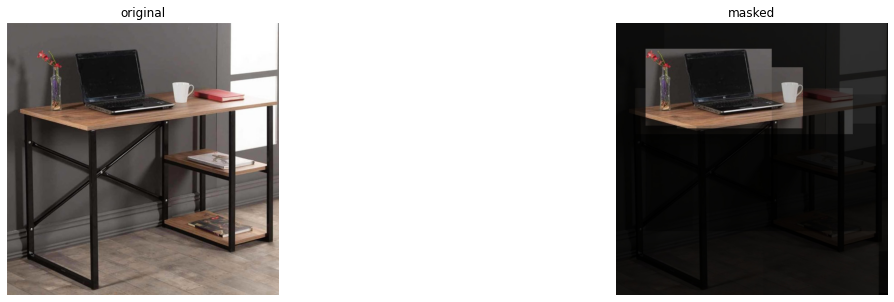

In [ ]:
lxmert = Lxmert()

PATH = '_path_to_jpg_' # jpg dosyası pathi verilmelidir
turkce_soru = 'Resimde neler var'

lxmert.resim_uzerinden_soru_cevap(PATH, turkce_soru)

## Arayüz

In [ ]:
!pip install flask-ngrok

In [ ]:
from flask import Flask, redirect, url_for, render_template, request, flash
from flask_ngrok import run_with_ngrok

In [ ]:
# Burada web_dependencies klasörü içerisinde bulunan klasörlerin pathi verilmelidir.
template_folder = '_path_to_templates_folder_'
static_folder = '_path_to_static_folder_'

In [ ]:
app = Flask(__name__, template_folder=template_folder, static_folder=static_folder)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/", methods=['GET', 'POST'])
def home():
  if request.method == 'POST':
    konu = request.form["topic"]
    library.categorical_scraper(konu, PATH, 20, text_into_sentences_param=False)
    
  return render_template("index.html")

if __name__ == "__main__":

	#app.debug = True
	app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7c1c-35-229-254-225.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [26/Aug/2021 19:16:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/mobirise/css/mbr-additional.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/web/assets/mobirise-icons2/mobirise2.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/web/assets/mobirise-icons-bold/mobirise-icons-bold.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/bootstrap/css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/web/assets/mobirise-icons/mobirise-icons.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:08] "GET /static/assets/bootstrap/css/bootstrap-grid.min.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:09] "GET /static/assets/bootstrap/css/bootstrap-reboot.min.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:09] "GET /static/assets/dropdown/css/style.css HTTP/1.1" 200 -
127.0.0.1 - - [26/Aug/2021 19:16:09] "GET /static/as